# Lab | Unsupervised learning intro  - K-Means Clustering


t's the moment to perform clustering on the songs you collected. Remember that the ultimate goal of this little project is to improve the recommendations of artists. Clustering the songs will allow the recommendation system to limit the scope of the recommendations to only songs that belong to the same cluster - songs with similar audio features.

The experiments you did with the Spotify API and the Billboard web scraping will allow you to create a pipeline such that when the user enters a song, you:

1. Check whether or not the song is in the Billboard Hot 200.

2. Collect the audio features from the Spotify API.


After that, you want to send the Spotify audio features of the submitted song to the clustering model, which should return a cluster number.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np

from bs4 import BeautifulSoup
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

from sklearn.preprocessing import StandardScaler


from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import pairwise_distances_argmin_min

import random as r

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Loading csv file with web scraped data of popular songs (Billboard Hot 100 playlist and RollingStone The 100 Best Songs of 2022 playlist)

top_songs=pd.read_csv("top_songs.csv", index_col=0)
top_songs.head()

,artist,song
0,Morgan Wallen,last night
1,Luke Combs,fast car
2,Rema & Selena Gomez,calm down
3,Miley Cyrus,flowers
4,Lil Durk Featuring J. Cole,all my life


In [9]:
top_songs.shape

(200, 2)

In [3]:
# Loading the audio features collected from the Spotify API.

df4=pd.read_csv("both_playlists_audio_features.csv")
df4.head()

,Unnamed: 0,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,type,id,uri,track_href,analysis_url,duration_ms,time_signature,song_title,songs_id,artist
0,0,0.514,0.730,1,-5.934,1,0.0598,0.00146,0.000095,0.0897,...,audio_features,0VjIjW4GlUZAMYd2vXMi3b,spotify:track:0VjIjW4GlUZAMYd2vXMi3b,https://api.spotify.com/v1/tracks/0VjIjW4GlUZA...,https://api.spotify.com/v1/audio-analysis/0VjI...,200040,4,Blinding Lights,0VjIjW4GlUZAMYd2vXMi3b,The Weeknd
1,1,0.825,0.652,1,-3.183,0,0.0802,0.58100,0.000000,0.0931,...,audio_features,7qiZfU4dY1lWllzX7mPBI3,spotify:track:7qiZfU4dY1lWllzX7mPBI3,https://api.spotify.com/v1/tracks/7qiZfU4dY1lW...,https://api.spotify.com/v1/audio-analysis/7qiZ...,233713,4,Shape of You,7qiZfU4dY1lWllzX7mPBI3,Ed Sheeran
2,2,0.824,0.588,6,-6.400,0,0.0924,0.69200,0.000104,0.1490,...,audio_features,2XU0oxnq2qxCpomAAuJY8K,spotify:track:2XU0oxnq2qxCpomAAuJY8K,https://api.spotify.com/v1/tracks/2XU0oxnq2qxC...,https://api.spotify.com/v1/audio-analysis/2XU0...,209438,4,Dance Monkey,2XU0oxnq2qxCpomAAuJY8K,Tones And I
3,3,0.501,0.405,1,-5.679,1,0.0319,0.75100,0.000000,0.1050,...,audio_features,7qEHsqek33rTcFNT9PFqLf,spotify:track:7qEHsqek33rTcFNT9PFqLf,https://api.spotify.com/v1/tracks/7qEHsqek33rT...,https://api.spotify.com/v1/audio-analysis/7qEH...,182161,4,Someone You Loved,7qEHsqek33rTcFNT9PFqLf,Lewis Capaldi
4,4,0.760,0.479,2,-5.574,1,0.0466,0.55600,0.000000,0.0703,...,audio_features,3KkXRkHbMCARz0aVfEt68P,spotify:track:3KkXRkHbMCARz0aVfEt68P,https://api.spotify.com/v1/tracks/3KkXRkHbMCAR...,https://api.spotify.com/v1/audio-analysis/3KkX...,158040,4,Sunflower - Spider-Man: Into the Spider-Verse,3KkXRkHbMCARz0aVfEt68P,Post Malone


In [5]:
#drop the duplicated rows with the same song.

df5 = df4.drop_duplicates(subset='song_title')

In [8]:
df5.shape

(154, 22)

In [11]:
df5.columns

Index(['Unnamed: 0', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'type', 'id', 'uri', 'track_href', 'analysis_url',
       'duration_ms', 'time_signature', 'song_title', 'songs_id', 'artist'],
      dtype='object')

## K-Means Clustering

In [12]:
# Selecting the columns for X

X = df5.drop(columns=['Unnamed: 0','type', 'id', 'uri', 'track_href', 'analysis_url','song_title', 'songs_id', 'artist'])
X.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0.514,0.730,1,-5.934,1,0.0598,0.00146,0.000095,0.0897,0.334,171.005,200040,4
1,0.825,0.652,1,-3.183,0,0.0802,0.58100,0.000000,0.0931,0.931,95.977,233713,4
2,0.824,0.588,6,-6.400,0,0.0924,0.69200,0.000104,0.1490,0.513,98.027,209438,4
3,0.501,0.405,1,-5.679,1,0.0319,0.75100,0.000000,0.1050,0.446,109.891,182161,4
4,0.760,0.479,2,-5.574,1,0.0466,0.55600,0.000000,0.0703,0.913,89.911,158040,4


In [14]:
# Standardize the numerical data because K means clustering is based on distances between features.

scaler = StandardScaler()
scale_x = scaler.fit_transform(X)   #scale_x is an array
scale_x
#scale_x = pd.DataFrame(scale_x, index = X.index, columns=X.columns) #scale_x array to dataframe
#scale_x

array([[-0.85613997,  0.65915833, -1.2819802 , ...,  1.70907511,
        -0.41255878,  0.15471319],
       [ 1.4202142 ,  0.21807929, -1.2819802 , ..., -0.90627454,
         0.44471419,  0.15471319],
       [ 1.41289473, -0.14383172,  0.13834319, ..., -0.83481499,
        -0.17329731,  0.15471319],
       ...,
       [-0.52676396, -2.49625326,  1.2746019 , ..., -1.56690932,
        -0.10705361,  0.15471319],
       [-1.08304344, -1.75546667, -0.42978617, ...,  0.39843733,
         0.6089996 , -3.81625861],
       [-1.40509997, -2.60369559, -1.2819802 , ..., -0.18181418,
         1.81897829, -3.81625861]])

### Determining the optimal number of clusters (choosing the best K)

Before we apply our model we need to find the best number of clusters for K means Clustering

#### The "Elbow" Method -  sum of squares at each number of clusters is calculated 

In [15]:
# Using the quality metric inertia to find and choose the best K for our dataset (the optimal number of clusters)

K = range(1, 15) # different K values 

inertia = []

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)   #Fitting the model with a range of values for K
    kmeans.fit(scale_x)
    inertia.append(kmeans.inertia_)

inertia

[2002.0000000000002,
 1661.3756308107108,
 1515.747631710795,
 1409.1829673520424,
 1292.5284398019319,
 1202.1500121920467,
 1127.169667621867,
 1050.4184688102473,
 997.9325535537453,
 965.5815964554597,
 925.088775455638,
 898.3333626880444,
 878.9122865499314,
 839.3152534792641]

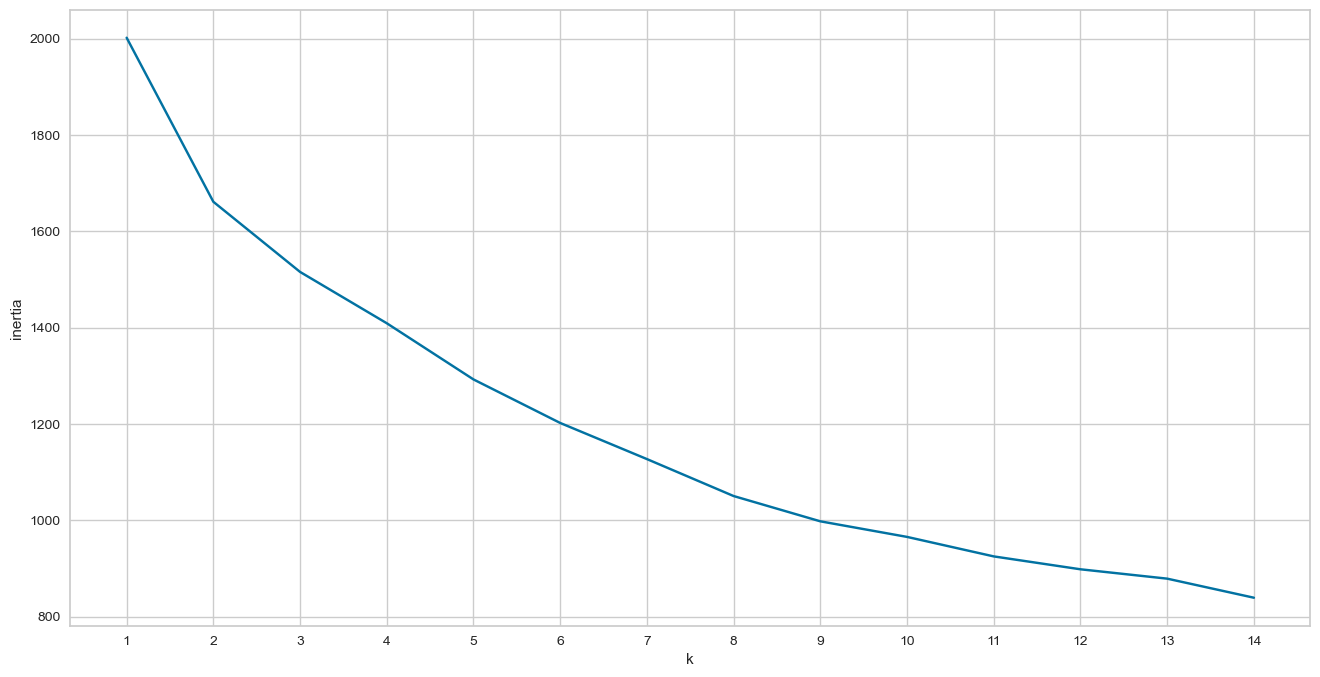

In [16]:
# Plot the inertia to visualize better the best K ( find the "elbow" in the plot)

plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.show()

It's not very clear where is the "elbow" in the above plot to find best K value, perhaps 2??

I am going to use Yellowbrick ("KElbowVisualizer") to find the elbow and see if we have a more clear answer.

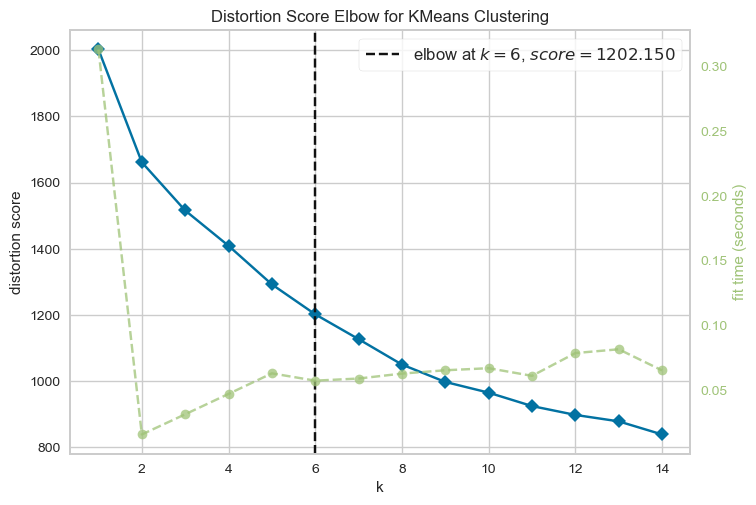

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [17]:
visualizer = KElbowVisualizer(kmeans, k=(1,15))

visualizer.fit(scale_x)    # Fit the data to the visualizer
visualizer.poof()

The suggested elbow is where K = 6. 

Let's use a different method, the Silhouette Score to see if best K remains the same.

#### Silhouette Method

The silhouette coefficient may provide a more objective answer to determine the optimal number of clusters.

Silhouette score is used to measure how dense and well-separated the clusters are, it ranges between -1 and 1, the higher the score more dense and separated are the clusters.


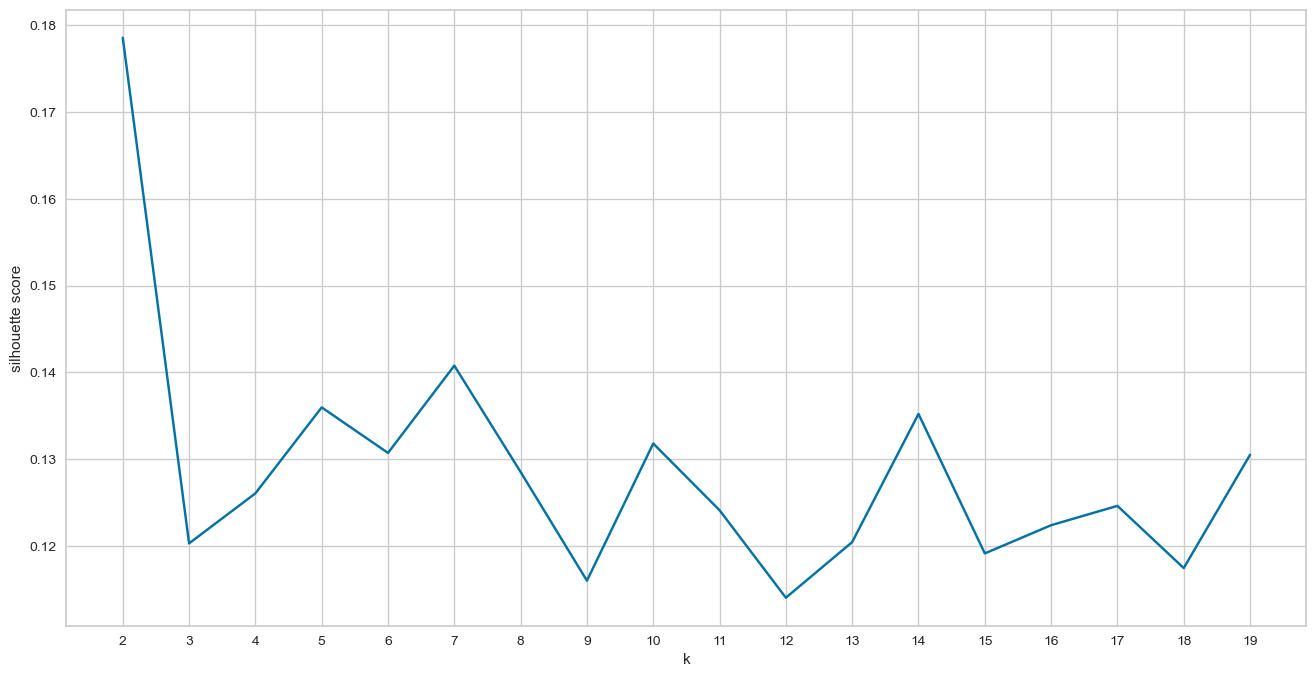

In [18]:
K = range(2, 20)

silhouette = [] #to store the silhouette scores

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scale_x)
    silhouette.append(silhouette_score(scale_x, kmeans.predict(scale_x)))


plt.figure(figsize=(16,8))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.show()

According to the above plot, **K = 2** seems to be the optimal number of clusters in the data, where the silhouette score is higher.

In [22]:
# Transform the data into 2D so we can assess the number of clusters visually with SilhouetteVisualizer.

from sklearn.decomposition import PCA  

pca = PCA(2) #reducing to 2 dimensions 
X_2D = pca.fit_transform(scale_x)  # scale_x df "compressed" into 2 columns.

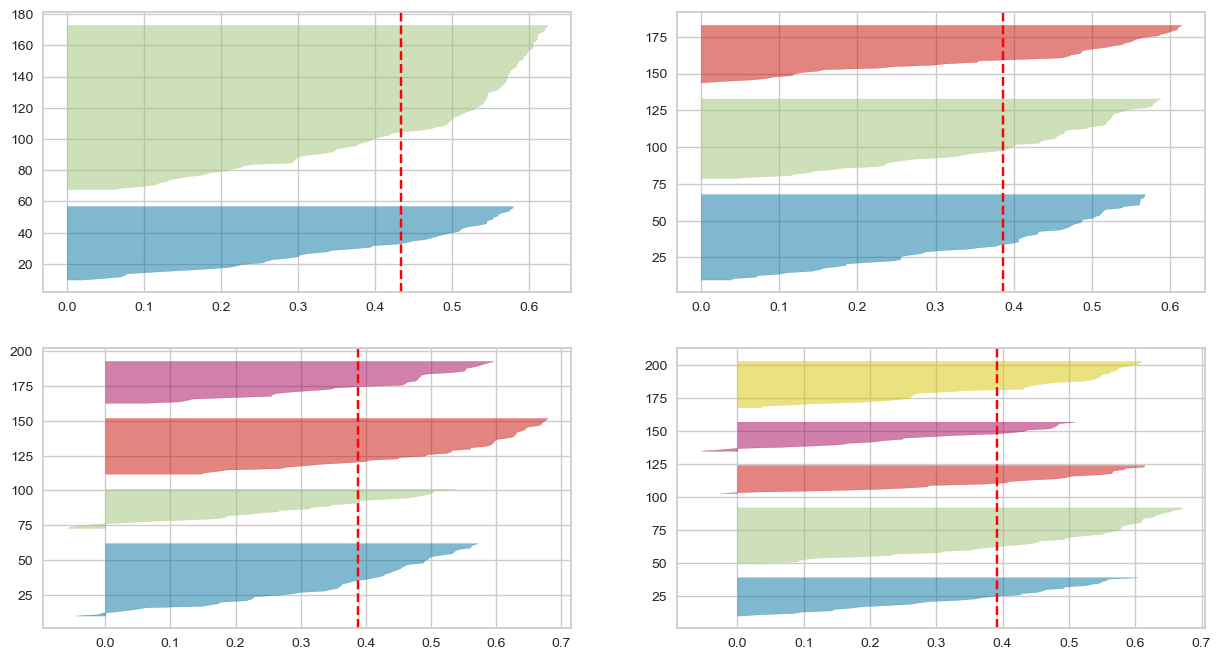

In [23]:
fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in [2, 3, 4, 5]:   #loop with K 2, 3 , 4, 5
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X_2D)

- All of the clusters are above the average silhouette scores.

- n_cluster 4 and 5 have wider fluctuations, so I am going to focus on n_cluster 2 and 3.


- Between n_cluster 2 and 3: Regarding cluster thickness, for the plot with n_cluster 3, the thickness looks more uniform when comparing with n_clusters=2, where one cluster is a lot more thicker than the other, therefore I am going to select the optimal **number of clusters = 3**!

In [25]:
#Let's train and predict with K-means Clustering with 3 clusters.

# In this case because we do not have a target (Unsupervised ML) we don't do Train Test Split, so we train and predict on X_test.

kmeans = KMeans(n_clusters=3, random_state=42)  
kmeans.fit_predict(scale_x) #predicting/assigning the clusters to our data points.
clusters = kmeans.predict(scale_x)
clusters

array([0, 1, 1, 2, 1, 0, 1, 0, 1, 1, 2, 2, 0, 1, 0, 0, 2, 1, 2, 1, 0, 1,
       2, 2, 2, 0, 0, 1, 2, 1, 1, 2, 2, 0, 1, 0, 2, 2, 1, 0, 1, 2, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 2, 1, 0, 1, 1, 1, 0, 0, 0, 2,
       1, 1, 0, 0, 2, 1, 1, 0, 0, 1, 1, 0, 0, 2, 2, 2, 1, 0, 1, 2, 2, 1,
       1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       0, 0, 2, 2, 0, 0, 2, 1, 0, 1, 1, 0, 1, 0, 2, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 2, 0, 0, 2, 1, 0, 0, 2, 1, 0, 1, 0, 2, 2, 0, 2, 2, 2])

In [27]:
# adding column song_title, artist, scale_x array and clusters array to the df.

scaled_df = pd.DataFrame(scale_x, columns=X.columns)
scaled_df['song_title'] = df5['song_title']
scaled_df['artist'] = df5['artist']
scaled_df['cluster'] = clusters
scaled_df.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,song_title,artist,cluster
0,-0.856140,0.659158,-1.281980,0.161153,0.714006,-0.331406,-0.983990,-0.166601,-0.638048,-0.624680,1.709075,-0.412559,0.154713,Blinding Lights,The Weeknd,0
1,1.420214,0.218079,-1.281980,1.569314,-1.400549,-0.077195,1.185235,-0.168719,-0.607108,1.935491,-0.906275,0.444714,0.154713,Shape of You,Ed Sheeran,1
2,1.412895,-0.143832,0.138343,-0.077379,-1.400549,0.074832,1.600709,-0.166410,-0.098411,0.142943,-0.834815,-0.173297,0.154713,Dance Monkey,Tones And I,1
3,-0.951293,-1.178671,-1.281980,0.291681,0.714006,-0.679076,1.821547,-0.168719,-0.498817,-0.144380,-0.421256,-0.867736,0.154713,Someone You Loved,Lewis Capaldi,2
4,0.944449,-0.760211,-0.997916,0.345427,0.714006,-0.495895,1.091659,-0.168719,-0.814591,1.858300,-1.117725,-1.481827,0.154713,Sunflower - Spider-Man: Into the Spider-Verse,Post Malone,1


In [28]:
scaled_df.cluster.value_counts()

1    57
0    53
2    44
Name: cluster, dtype: int64

## Building the Song Recommender

In [29]:
# Function that after user inputs a song, it recommends a random different song from the same playlist "top_songs"

def song_from_top100():
    user_input = input("Please insert a Song Name: ").lower()
    for i in top_songs['song']:
        if user_input in i:
            rows = top_songs.shape[0]
            random_row = r.randrange(rows)
            print('\n [Your Recommended Artist and Song:')
            return ' - '.join(top_songs.iloc[random_row,:])

In [50]:
# Function that recommends a different song with similar characteristics,  if user inputs a song that is not in "top_songs" playlist, based on audio features (same cluster) from a spotify playlist.

def song_audio_features():
    user_input = input("Please insert a Song Name: ").lower()
    sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id="af3a4e21d9974f798b0ddef081728f2b",
                                                           client_secret="99a65d20eff04d64bcf24b11824dffc4"))
    results = sp.search(q=f'track:{user_input}', limit=1)
    track_id = results['tracks']['items'][0]['id']  #obtain user input song id
    
    audio_features = sp.audio_features(track_id)   # get song features with the obtained id  
    
    df_ = pd.DataFrame(audio_features) # create dataframe
    new_features = df_[X.columns]
    
    scaled_x = scaler.transform(new_features) # scale features
    
    
    cluster_pred = kmeans.predict(scaled_x) # predict cluster of user input song 
    
    filtered_df = scaled_df[scaled_df['cluster'] == cluster_pred[0]][X.columns]   # filter dataset to predicted cluster(cluster is an array with only 1 element therefore index 0)
 
    closest, _ = pairwise_distances_argmin_min(scaled_x, filtered_df)  #get closest song from filtered dataset with same cluster as user input song

    print('\n [Your Recommended Artist and Song:')
    return ' - '.join([scaled_df.loc[closest]['song_title'].values[0], scaled_df.loc[closest]['artist'].values[0]])


In [32]:
# Both functions together

def song_recommender():
    user_input = input("Please insert a Song Name: ").lower()
    for i in top_songs['song']:
        if user_input in i:
            rows = top_songs.shape[0]
            random_row = r.randrange(rows)
            print('\n [Your Recommended Artist and Song:')
            return ' - '.join(top_songs.iloc[random_row,:])
    if user_input not in i:
        sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id="af3a4e21d9974f798b0ddef081728f2b",
                                                           client_secret="99a65d20eff04d64bcf24b11824dffc4"))
        results = sp.search(q=f'track:{user_input}', limit=1)
        track_id = results['tracks']['items'][0]['id']  #obtain user input song id
        audio_features = sp.audio_features(track_id)   # get song features with the obtained id  
            
        df_ = pd.DataFrame(audio_features) # create dataframe
        new_features = df_[X.columns]

        scaled_x = scaler.transform(new_features) # scale features for the kmeans model
        cluster_pred = kmeans.predict(scaled_x) # predict cluster of user input song 

        filtered_df = scaled_df[scaled_df['cluster'] == cluster_pred[0]][X.columns]   # filter dataset to predicted cluster(cluster is an array with only 1 element therefore index 0)

        closest, _ = pairwise_distances_argmin_min(scaled_x, filtered_df)  #get closest song from filtered dataset with same cluster as user input song
            
        print('\n Your Recommended Song and Artist:')
        return ' - '.join([scaled_df.loc[closest]['song_title'].values[0], scaled_df.loc[closest]['artist'].values[0]])


In [37]:
song_recommender()

Please insert a Song Name: Calm Down

 [Your Recommended Artist and Song:


'Rod Wave - fight the feeling'

In [34]:
top_songs.head()

,artist,song
0,Morgan Wallen,last night
1,Luke Combs,fast car
2,Rema & Selena Gomez,calm down
3,Miley Cyrus,flowers
4,Lil Durk Featuring J. Cole,all my life


In [36]:
# Example

top_songs[top_songs['song']=='planb']

,artist,song
81,Megan Thee Stallion,planb


In [38]:
scaled_df.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,song_title,artist,cluster
0,-0.856140,0.659158,-1.281980,0.161153,0.714006,-0.331406,-0.983990,-0.166601,-0.638048,-0.624680,1.709075,-0.412559,0.154713,Blinding Lights,The Weeknd,0
1,1.420214,0.218079,-1.281980,1.569314,-1.400549,-0.077195,1.185235,-0.168719,-0.607108,1.935491,-0.906275,0.444714,0.154713,Shape of You,Ed Sheeran,1
2,1.412895,-0.143832,0.138343,-0.077379,-1.400549,0.074832,1.600709,-0.166410,-0.098411,0.142943,-0.834815,-0.173297,0.154713,Dance Monkey,Tones And I,1
3,-0.951293,-1.178671,-1.281980,0.291681,0.714006,-0.679076,1.821547,-0.168719,-0.498817,-0.144380,-0.421256,-0.867736,0.154713,Someone You Loved,Lewis Capaldi,2
4,0.944449,-0.760211,-0.997916,0.345427,0.714006,-0.495895,1.091659,-0.168719,-0.814591,1.858300,-1.117725,-1.481827,0.154713,Sunflower - Spider-Man: Into the Spider-Verse,Post Malone,1


In [41]:
#Example: A song that is not on top_songs playlist.

scaled_df[scaled_df['song_title']=='Nothing Else Matters']

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,song_title,artist,cluster


In [42]:
song_recommender()

Please insert a Song Name: Nothing Else Matters

 Your Recommended Song and Artist:


'Something Just Like This - The Chainsmokers'

In [45]:
scaled_df[scaled_df['song_title']=='Something Just Like This']    # Cluster 1

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,song_title,artist,cluster
30,-0.102235,0.121947,1.558667,-0.26626,-1.400549,-0.681568,-0.803053,-0.1684,0.038091,-0.14438,-0.660802,0.787058,0.154713,Something Just Like This,The Chainsmokers,1
